In [18]:
import numpy as np
import cv2 as cv # SIFT descriptors
import os # file reading

# Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt

In [19]:
# Read images

images = []
labels = []

for subdir in os.listdir("fruit_dataset"):
    for file_name in os.listdir("fruit_dataset/" + subdir):
        label = file_name.split("_")[0:2] # Extract label
        labels.append(label) # Add label to dataset
        
        # Make images readable by OpenCV
        image = cv.imread("fruit_dataset/" + subdir + "/" + file_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        images.append(image) # Add image to dataset
images = np.array(images)
labels = np.array(labels)

print(images.shape, labels.shape)

(1655, 300, 300, 3) (1655, 2)


In [20]:
SIFT = cv.SIFT_create(1000)
SIFT_descriptors = []

for image in images:
    image_bw = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    keypoints, descriptors = SIFT.detectAndCompute(image_bw, None)

    # Pad descriptors to prevent non-homogeneous data
    max_descriptors = 1000
    descriptors_padded = np.zeros((max_descriptors, descriptors.shape[1]), dtype=np.float32)
    descriptors_padded[:descriptors.shape[0], :] = descriptors[:max_descriptors, :]
    
    SIFT_descriptors.append(descriptors_padded.flatten())

SIFT_descriptors = np.array(SIFT_descriptors)

{'rotten_peach': 57, 'rotten_pomegranate': 44, 'fresh_pomegranate': 44, 'fresh_peach': 34, 'rotten_strawberry': 36, 'fresh_strawberry': 35}


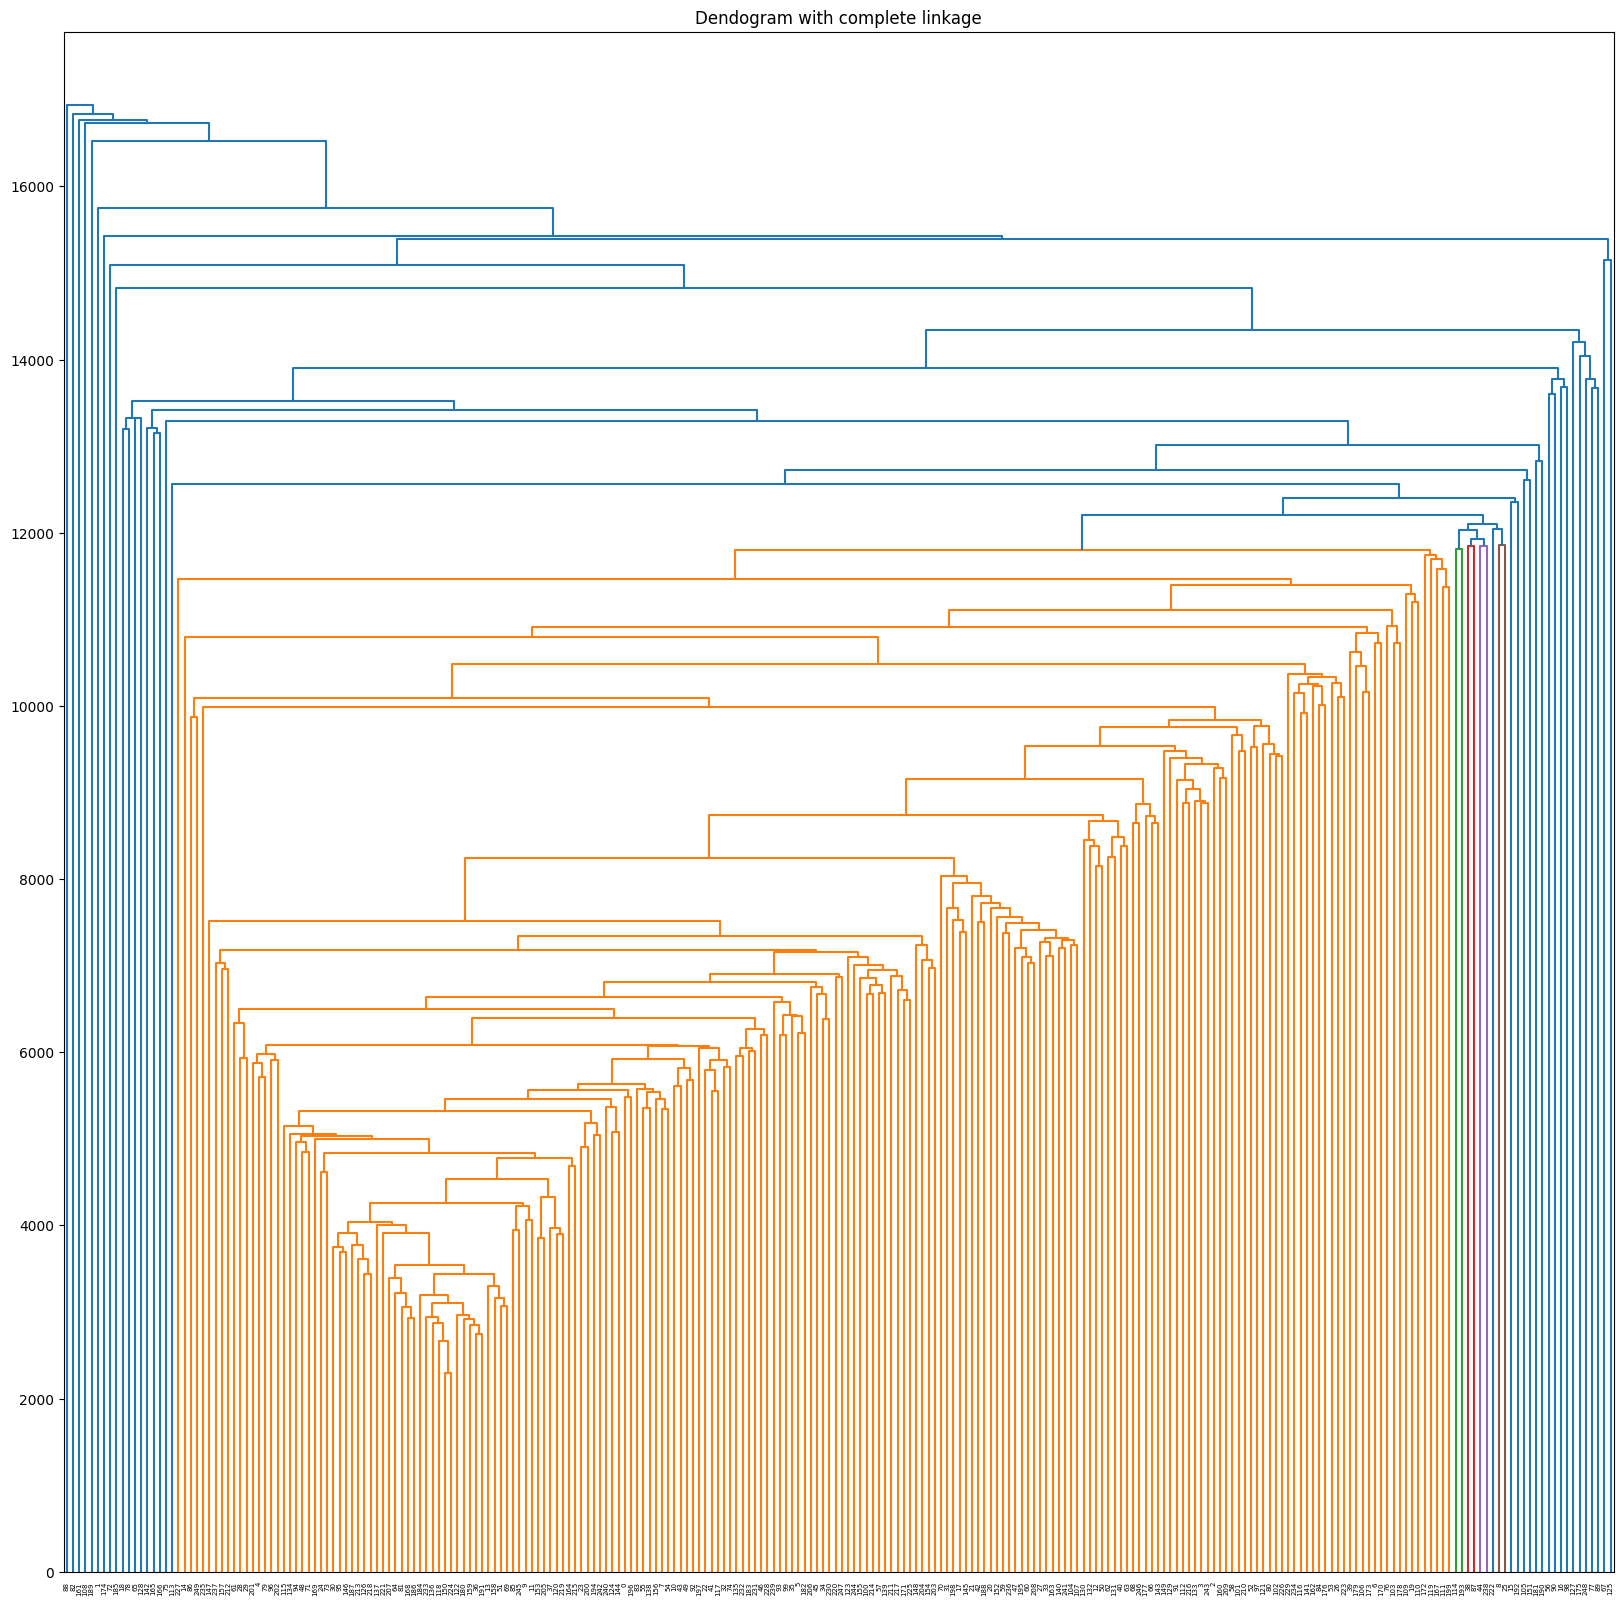

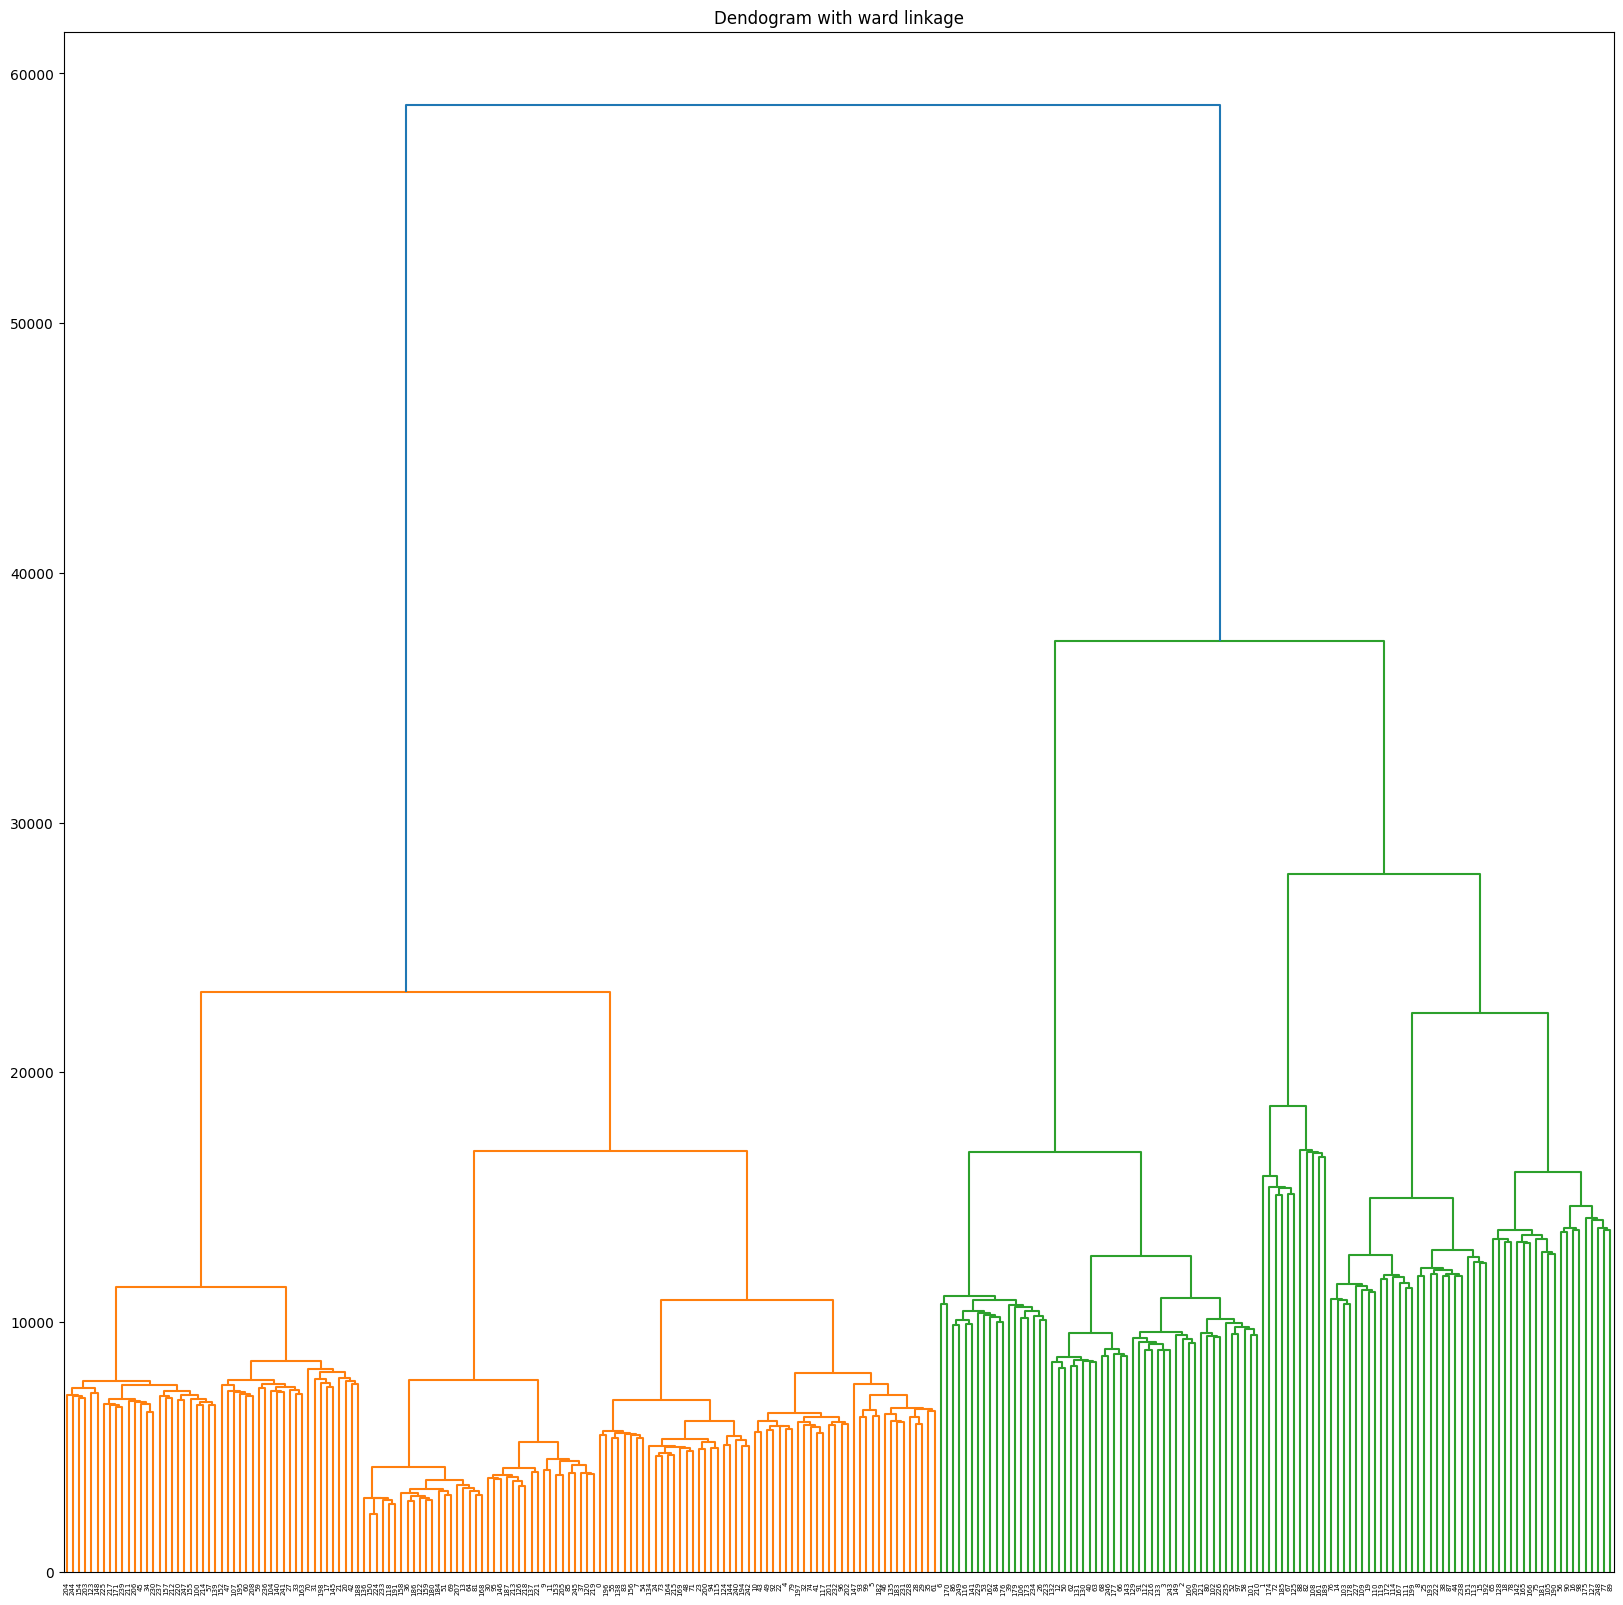

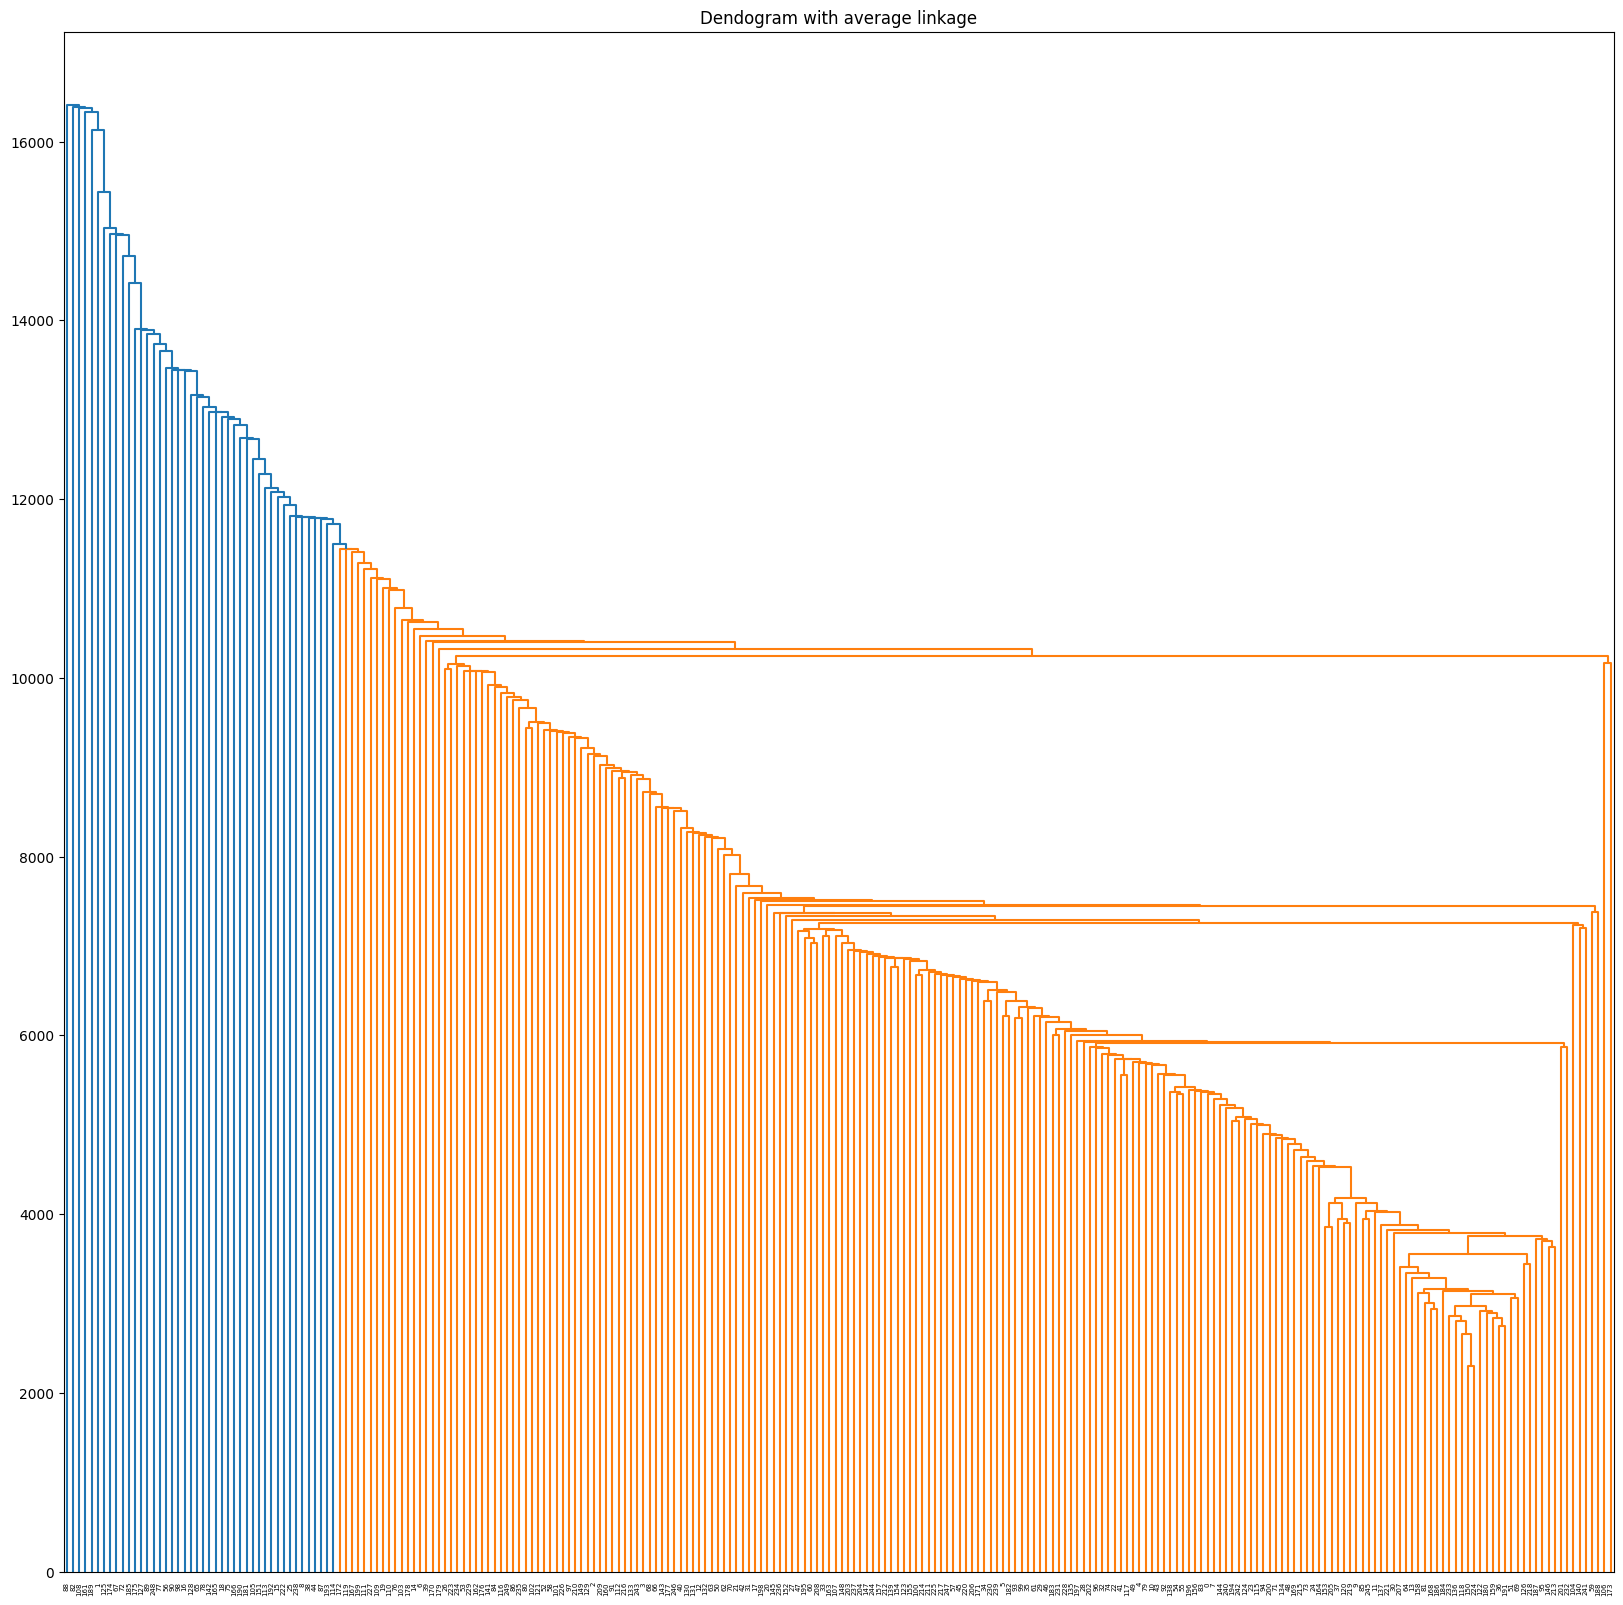

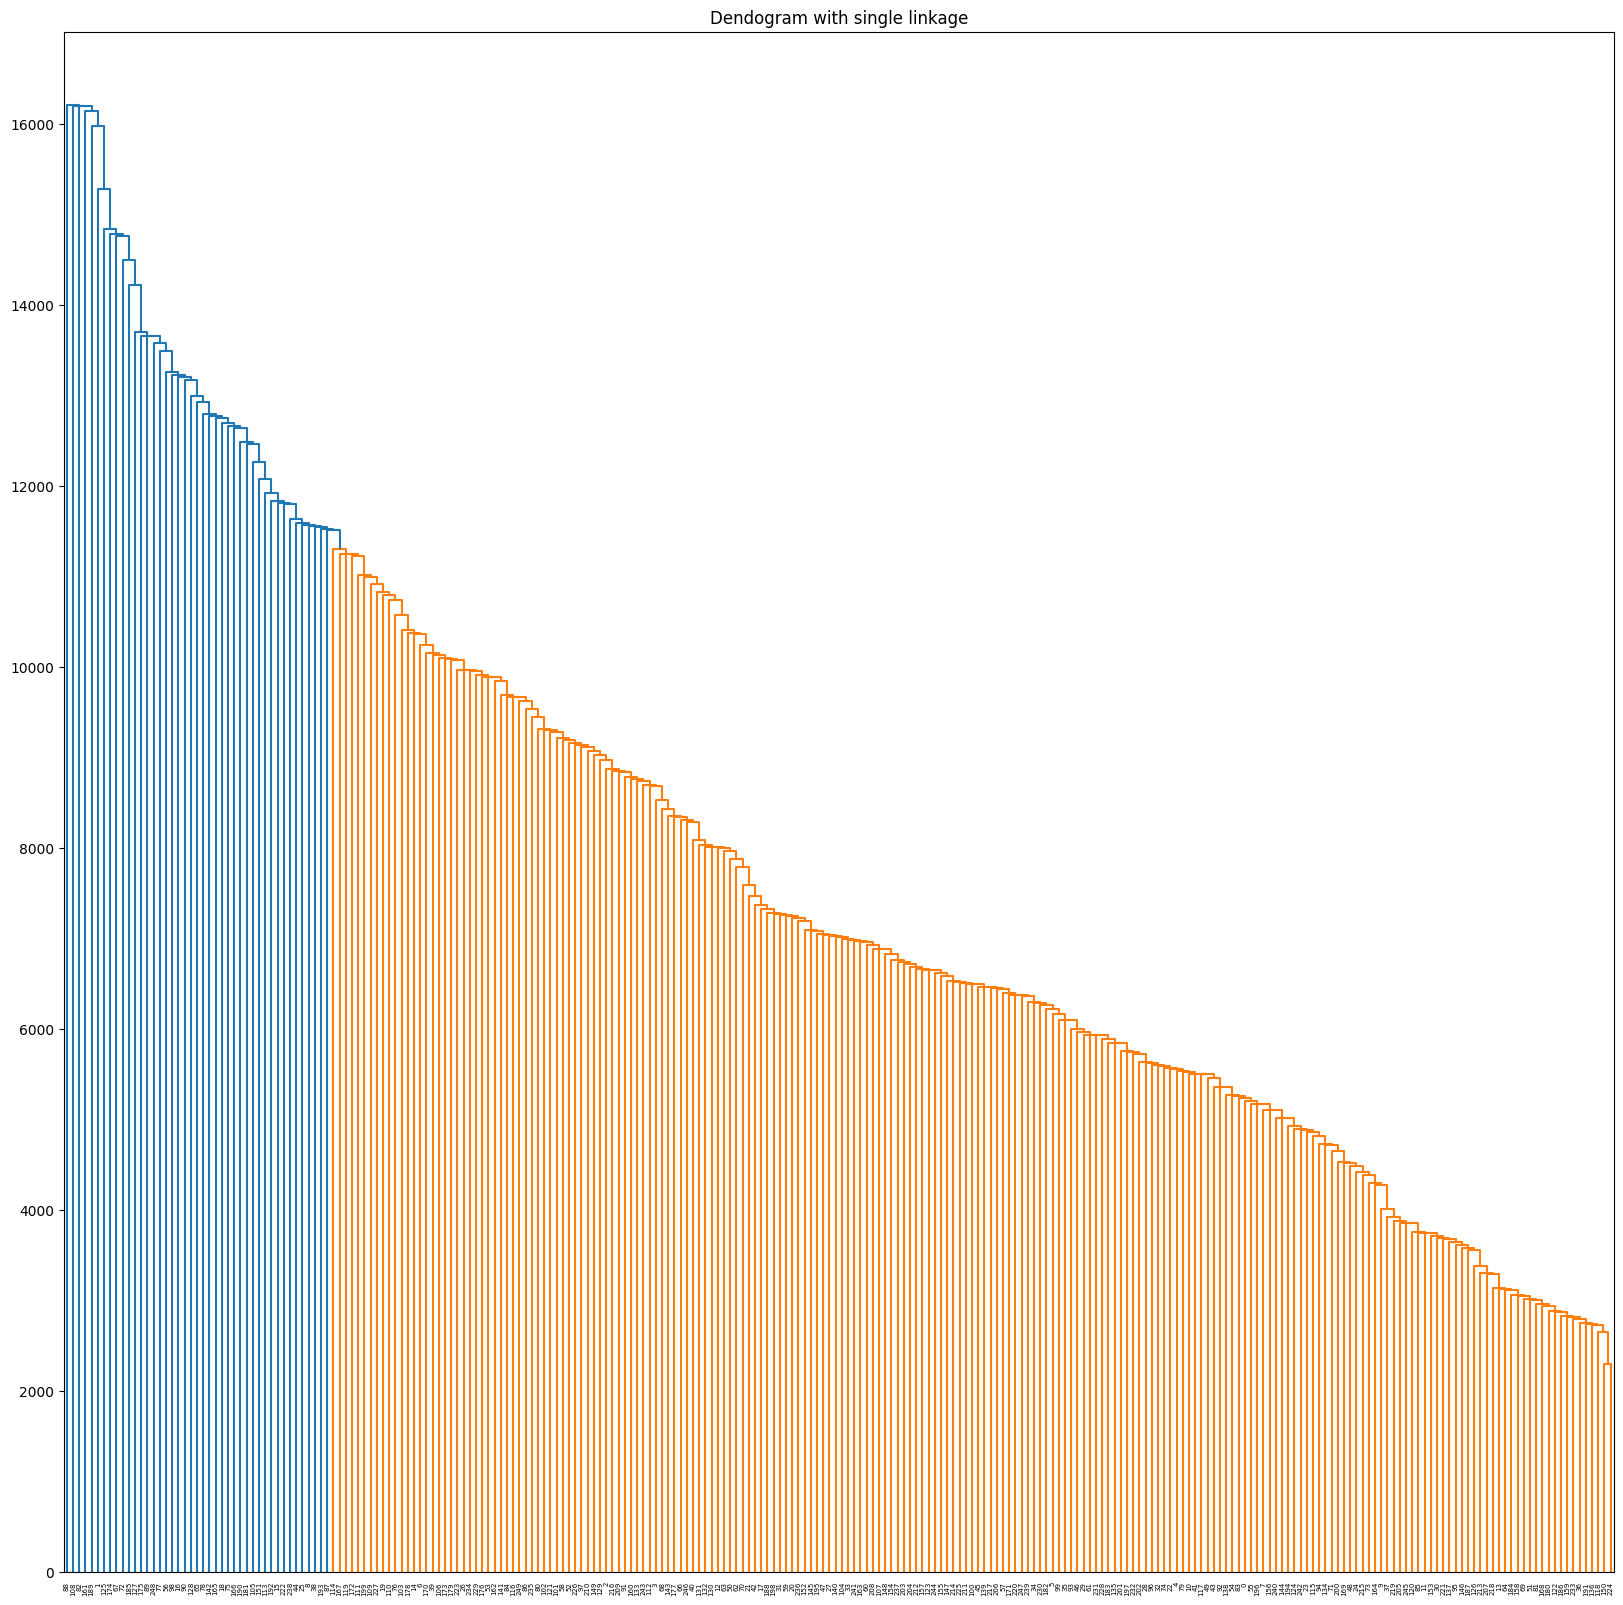

In [21]:
# Build a dendogram
np.random.seed(678)
subset_indices = np.random.choice(len(SIFT_descriptors), size=250, replace=False)

image_descriptors_subset = SIFT_descriptors[subset_indices]
labels_subset = labels[subset_indices]

# Look at the random data to make sure it's somewhat uniform and well-representative
freqs = dict()
for label in labels_subset:
    label_str = '_'.join(label)
    if label_str not in freqs:
        freqs[label_str] = 0
    freqs[label_str] += 1
print(freqs)

plt.figure(figsize =(20, 20))
plt.title('Dendogram with complete linkage')
dendrogram1 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='complete')))
plt.show()


plt.figure(figsize =(20, 20))
plt.title('Dendogram with ward linkage')
dendrogram2 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='ward')))
plt.show()

plt.figure(figsize =(20, 20))
plt.title('Dendogram with average linkage')
dendrogram3 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='average')))
plt.show()

plt.figure(figsize =(20, 20))
plt.title('Dendogram with single linkage')
dendrogram4 = shc.dendrogram((shc.linkage(np.vstack(image_descriptors_subset), method ='single')))
plt.show()

Ward linkage appears to have the most natural division into 6 clusters as expected, though the dendograms are concerning because neither shows 6 distinct clusters, despite our classes clearly being divided into 6.

In [22]:
n_clusters = 6
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean').fit(SIFT_descriptors)

In [32]:
# Print results
cluster_labels = clustering.labels_

clusters = {}
for idx, cluster_id in enumerate(cluster_labels):
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(labels[idx])

for cluster_id, data_points in clusters.items():
    print("Cluster " + str(cluster_id) + ":")
    print("Total data points: " + str(len(data_points)))
    label_strs, label_counts = np.unique([str(label) for label in data_points], return_counts=True)
    for label, count in zip(label_strs, label_counts):
        print("Label " + str(label) + ": " + str(count) + " occurrences")
    print()

Cluster 3:
Total data points: 179
Label ['fresh' 'peach']: 1 occurrences
Label ['fresh' 'pomegranate']: 12 occurrences
Label ['fresh' 'strawberry']: 60 occurrences
Label ['rotten' 'peach']: 22 occurrences
Label ['rotten' 'pomegranate']: 28 occurrences
Label ['rotten' 'strawberry']: 56 occurrences

Cluster 2:
Total data points: 168
Label ['fresh' 'pomegranate']: 1 occurrences
Label ['fresh' 'strawberry']: 68 occurrences
Label ['rotten' 'peach']: 9 occurrences
Label ['rotten' 'pomegranate']: 27 occurrences
Label ['rotten' 'strawberry']: 63 occurrences

Cluster 0:
Total data points: 409
Label ['fresh' 'peach']: 10 occurrences
Label ['fresh' 'pomegranate']: 47 occurrences
Label ['fresh' 'strawberry']: 70 occurrences
Label ['rotten' 'peach']: 107 occurrences
Label ['rotten' 'pomegranate']: 79 occurrences
Label ['rotten' 'strawberry']: 96 occurrences

Cluster 4:
Total data points: 264
Label ['fresh' 'peach']: 46 occurrences
Label ['fresh' 'pomegranate']: 52 occurrences
Label ['fresh' 'strawb

**Analysis**

Ideally, each cluster would show a dominant label; most elements with that label would be within that cluster, and few without it would be. While there is some correlation between labels and clusters (clusters 2 and 3 are dominated by strawberries, though the clustering algorithm failed to differentiate them based on freshness, and cluster 1 is dominated by peaches), there is quite a bit of noise and not a clear correspondence between labels and clusters. It also seems that the clustering was far better at differentiating types of fruit than actually differentiating fresh vs rotten fruit. Overall, it appears that hierarchical clustering may not be the best way to classify this data—indeed, supervised approaches are far more common for classification problems like this.